## Clustering Analysis

In this notebook, we show our cluster analysis comparing play styles in Club (NBA + other international) leagues and FIBA. Our approach is to use K-means clustering to cluster players from the three leagues, and then analyze the way players map from cluster to cluster across club play and FIBA play. We use play type distributions parsed from the Synergy data as the features for our clustering. We also list some of our observations and next steps.

## Load Data
We load three sheets with results from parsing the Synergy data for FIBA, NBA and International competitions, and merge the three dataframes. Note that this data is from 2013-2019. We remove any rows with fewer than 50 total plays.

In [1]:
import pandas as pd
import numpy as np

sources = ['FIBA', 'INTL', 'NBA']
dfs = []
for source in sources:
    df = pd.read_csv('../Play Counts/' + source + '_Play_Counts.csv', encoding='utf-8')
    df.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
    df['Source'] = source
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)



df['Type'] = df['Source'].apply(lambda x: 'FIBA' if x=='FIBA' else 'Club')
df = df[df['Total'] >= 50] # Keep only rows with at least 50 plays

df['CleanName'] = df['Player'].apply(lambda n: ''.join([c for c in n if c.isalpha() or c==' ' or c=='-']).upper()) # Merging duplicate names
df = df.groupby(['CleanName',  'Source', 'Type']).sum(min_count=1)
df = df.sort_values('Total', ascending=False)
df

,,,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total
CleanName,Source,Type,,,,,,,,,,,
JAMES HARDEN,NBA,Club,9932,1052,3056,7091,591,38,234,513,382,584,23473
RUSSELL WESTBROOK,NBA,Club,9795,1155,3599,3348,1625,17,273,920,196,411,21339
LEBRON JAMES,NBA,Club,6644,957,3063,4241,2576,351,708,676,281,233,19730
DAMIAN LILLARD,NBA,Club,11599,1047,1596,2776,35,14,373,378,714,980,19512
DEMAR DEROZAN,NBA,Club,7472,1395,1303,2731,1583,31,296,422,1398,644,17275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAVIS GEKS,INTL,Club,14,20,3,3,0,0,0,6,4,0,50
SHAQUILLE CLEARE,FIBA,FIBA,0,0,3,1,20,16,3,7,0,0,50
MITCHELL MCCARRON,FIBA,FIBA,12,10,15,0,0,0,2,8,1,2,50


Now, we convert the columns from play count totals to proportions, and prepare a dataframe to be passed into the clustering algorithm.

In [2]:
play_types = ['P&R Ball Handler', 'Spot-Up', 'Transition', 'ISO', 'Post-Up', 'P&R Roll Man', 'Cut', 'Offensive Rebound', 'Off Screen', 'Hand Off']

for p in play_types:
    df['% ' + p] = df[p] / df['Total']

proportions_df = df[['% ' + p for p in play_types]].copy()
proportions_df

,,,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
CleanName,Source,Type,,,,,,,,,,
JAMES HARDEN,NBA,Club,0.423124,0.044817,0.130192,0.302092,0.025178,0.001619,0.009969,0.021855,0.016274,0.024880
RUSSELL WESTBROOK,NBA,Club,0.459019,0.054126,0.168658,0.156896,0.076152,0.000797,0.012793,0.043114,0.009185,0.019261
LEBRON JAMES,NBA,Club,0.336746,0.048505,0.155246,0.214952,0.130563,0.017790,0.035884,0.034263,0.014242,0.011809
DAMIAN LILLARD,NBA,Club,0.594455,0.053659,0.081796,0.142271,0.001794,0.000718,0.019116,0.019373,0.036593,0.050226
DEMAR DEROZAN,NBA,Club,0.432533,0.080753,0.075427,0.158090,0.091635,0.001795,0.017135,0.024428,0.080926,0.037279
...,...,...,...,...,...,...,...,...,...,...,...,...
DAVIS GEKS,INTL,Club,0.280000,0.400000,0.060000,0.060000,0.000000,0.000000,0.000000,0.120000,0.080000,0.000000
SHAQUILLE CLEARE,FIBA,FIBA,0.000000,0.000000,0.060000,0.020000,0.400000,0.320000,0.060000,0.140000,0.000000,0.000000
MITCHELL MCCARRON,FIBA,FIBA,0.240000,0.200000,0.300000,0.000000,0.000000,0.000000,0.040000,0.160000,0.020000,0.040000


## Clustering

We run K-means clustering for k (the number of clusters) between 5 and 15. We plot the inertia for each k. The inertia (also known as within-cluster sum-of-squares) measures how internally coherent each cluster is, with a lower inertia representing a better clustering model. See https://scikit-learn.org/stable/modules/clustering.html for more details.

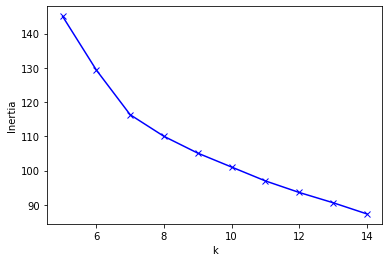

In [3]:
from sklearn.cluster import KMeans
inertias = []
for i in range(5, 15):
    test_model = KMeans(n_clusters=i, random_state = 42)
    test_model.fit(proportions_df)
    inertias.append(test_model.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

From this graph, we see using the elbow method that the best number of clusters is 7. Therefore, let us run the model with 7 clusters again and analyze its results.

In [14]:
num_clusters = 7
model = KMeans(n_clusters=num_clusters, random_state=42)
model.fit(proportions_df)

# Add clusters to proportions_df
df['Cluster'] = model.labels_
replacements = {0: 1, 1: 3, 2: 0, 3: 2, 4: 5, 5: 4, 6: 6} # Relevelling to align with previous order
df['Cluster'] = df['Cluster'].replace(replacements)
df['Cluster'].value_counts()

1    1105
6    1049
2     982
0     857
4     841
3     728
5     555
Name: Cluster, dtype: int64

We save a file with each player's play counts and clusters for the three sources (NBA, FIBA, and INTL) in one CSV file.

In [15]:
cols = play_types + ['Cluster']
temp_dfs = []
for source in sources:
    temp_df = df.xs(source, level=1).droplevel(level=1)[[col for col in cols]]
    temp_df.columns = [source + '_' + c for c in temp_df.columns]
    temp_dfs.append(temp_df)
output_df = pd.concat(temp_dfs, axis=1)
output_df.to_csv("NBA_INTL_FIBA_Clustering_Encoded.csv", encoding='latin-1')
output_df

,FIBA_P&R Ball Handler,FIBA_Spot-Up,FIBA_Transition,FIBA_ISO,FIBA_Post-Up,FIBA_P&R Roll Man,FIBA_Cut,FIBA_Offensive Rebound,FIBA_Off Screen,FIBA_Hand Off,...,NBA_Spot-Up,NBA_Transition,NBA_ISO,NBA_Post-Up,NBA_P&R Roll Man,NBA_Cut,NBA_Offensive Rebound,NBA_Off Screen,NBA_Hand Off,NBA_Cluster
CleanName,,,,,,,,,,,,,,,,,,,,,
BOGDAN BOGDANOVIC,352.0,167.0,96.0,94.0,31.0,1.0,34.0,31.0,87.0,69.0,...,519.0,353.0,194.0,103.0,9.0,77.0,87.0,245.0,229.0,1.0
LUIS SCOLA,0.0,122.0,105.0,19.0,304.0,167.0,125.0,97.0,20.0,1.0,...,656.0,296.0,39.0,537.0,623.0,274.0,386.0,75.0,11.0,0.0
FACUNDO CAMPAZZO,595.0,74.0,140.0,70.0,0.0,2.0,9.0,24.0,16.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MANTAS KALNIETIS,684.0,69.0,58.0,36.0,3.0,0.0,15.0,23.0,19.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOJAN BOGDANOVIC,205.0,119.0,113.0,149.0,124.0,2.0,39.0,22.0,92.0,9.0,...,1564.0,1274.0,541.0,344.0,70.0,365.0,237.0,1064.0,379.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YANTE MATEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,7.0,2.0,0.0,5.0,9.0,11.0,0.0,2.0,0.0
ZHOU QI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,7.0,0.0,2.0,4.0,4.0,6.0,2.0,3.0,4.0
BJ JOHNSON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,14.0,3.0,0.0,0.0,2.0,5.0,1.0,4.0,6.0


# Analysis

To get a sense of the different clusters, let's print a few players from each cluster. We've assigned names to the clusters based on our knowledge of these players and the cluster centres produced by the clustering algorithm. Keep in mind that these stats are from previous NBA seasons, and some players' styles may have changed since then.

In [16]:
player_types = ['Stretch bigs', 'Playmakers', 'Ball handlers', 'Driving bigs', 'Spot-up shooters', 'Low-post bigs', 'Off-ball wings']
for i in range(7):
    print(i, '-', player_types[i])
    print(', '.join(df[df['Cluster'] == i].head(10).index.get_level_values(0).tolist()))
    print()

0 - Stretch bigs
ANTHONY DAVIS, CARMELO ANTHONY, PAUL MILLSAP, KEVIN LOVE, HARRISON BARNES, THADDEUS YOUNG, AL HORFORD, SERGE IBAKA, DRAYMOND GREEN, BROOK LOPEZ

1 - Playmakers
JAMES HARDEN, RUSSELL WESTBROOK, LEBRON JAMES, DEMAR DEROZAN, STEPHEN CURRY, KEVIN DURANT, BRADLEY BEAL, KYLE LOWRY, PAUL GEORGE, JIMMY BUTLER

2 - Ball handlers
DAMIAN LILLARD, KEMBA WALKER, CHRIS PAUL, JOHN WALL, KYRIE IRVING, JEFF TEAGUE, GORAN DRAGIC, DENNIS SCHRODER, ISAIAH THOMAS, JRUE HOLIDAY

3 - Driving bigs
ANDRE DRUMMOND, DERRICK FAVORS, STEVEN ADAMS, MARCIN GORTAT, DEANDRE JORDAN, ROBIN LOPEZ, TRISTAN THOMPSON, MASON PLUMLEE, HASSAN WHITESIDE, RUDY GOBERT

4 - Spot-up shooters
TREVOR ARIZA, JAE CROWDER, DANNY GREEN, DEMARRE CARROLL, ROBERT COVINGTON, PJ TUCKER, AL FAROUQ AMINU, MARVIN WILLIAMS, NIKOLA MIROTIC, COREY BREWER

5 - Low-post bigs
LAMARCUS ALDRIDGE, BLAKE GRIFFIN, DEMARCUS COUSINS, NIKOLA VUCEVIC, MARC GASOL, KARL-ANTHONY TOWNS, ENES KANTER, ZACH RANDOLPH, NIKOLA JOKIC, PAU GASOL

6 - Off-

We also print out the cluster centres and save them to a CSV file for future reference.

In [17]:
cluster_centres_df = pd.DataFrame(model.cluster_centers_, columns = play_types).transpose().rename(columns=replacements) # Relevelling to align with previous order
cluster_centres_df = cluster_centres_df.reindex(sorted(cluster_centres_df.columns), axis=1)
cluster_centres_df.columns = player_types
cluster_centres_df.to_csv("cluster-centres.csv")
cluster_centres_df

,Stretch bigs,Playmakers,Ball handlers,Driving bigs,Spot-up shooters,Low-post bigs,Off-ball wings
P&R Ball Handler,0.020139,0.430725,0.601623,0.002400,0.061061,0.002793,0.228555
Spot-Up,0.258712,0.183391,0.127126,0.073282,0.407093,0.073694,0.270893
Transition,0.104901,0.125955,0.088421,0.070213,0.140399,0.055185,0.158608
ISO,0.051783,0.092271,0.084847,0.017422,0.037210,0.024256,0.068468
Post-Up,0.168711,0.015544,0.005632,0.157475,0.045555,0.357767,0.027159
P&R Roll Man,0.109480,0.001115,0.000377,0.215223,0.040299,0.152949,0.004547
Cut,0.112834,0.026317,0.012913,0.213868,0.076890,0.152053,0.045539
Offensive Rebound,0.137068,0.044100,0.028995,0.244115,0.114538,0.172920,0.067200
Off Screen,0.029360,0.048523,0.023081,0.004000,0.057840,0.006859,0.089482
Hand Off,0.007012,0.032059,0.026985,0.002002,0.019116,0.001526,0.039548


Here are the labels we use for each cluster, and the key play types for each:

0 - Stretch bigs: Spot-Up, Post-Up, Offensive Rebound  
1 - Playmakers: Isolation, P&R Ball Handler, Spot-Up  
2 - Ball handlers: P&R Ball Handler, Isolation, Spot-Up  
3 - Driving bigs: Offensive Rebound, Cut, P&R Man  
4 - Spot-up Shooters: Spot-Up, Transition, Off Screen  
5 - Low-post bigs: Post-Up, Offensive Rebound, P&R Man  
6 - Off-Ball wings: Off Screen, Spot-Up, Transition


We notice that clusters 0, 3, and 5 contain more traditional big-men, and expect confusuion between these. Meanwhile, clusters 1, 2, and 4 are also similar, so we expect confusion between these.

We create a confusion matrix mapping players' clusters from Club to FIBA, according to the format below:

| Club\FIBA  | 0 | 1 | 2 |
|-----------|---|---|---|
| 0         | 5 | 2 | 0 |
| 1         | 1 | 8 | 3 |
| 2         | 0 | 4 | 6 |

For example, the confusion matrix above shows that 8 players were clustered into cluster 1 for both leagues, while 2 players are clustered in cluster 0 for their Club stats but cluster 1 for their FIBA stats.

In [18]:
source_clusters = [output_df[[c for c in output_df.columns if c.startswith(source)]][source + '_Cluster'].dropna() for source in sources]
intl_players = [p for p in source_clusters[1].index if p not in source_clusters[2].index]
nba_players = source_clusters[2].index
club_clusters = pd.concat([source_clusters[1].loc[intl_players], source_clusters[2]])
players_to_keep = [p for p in club_clusters.index if p in source_clusters[0].index]
club_clusters = club_clusters.loc[players_to_keep].sort_index()
fiba_clusters = source_clusters[0].loc[players_to_keep].sort_index()

from sklearn.metrics import confusion_matrix
if all(club_clusters.index == fiba_clusters.index):
    cm = confusion_matrix(club_clusters, fiba_clusters)
print("{:.2f}% of players stayed in the same cluster.".format(sum(np.diag(cm))/sum(sum(cm)) * 100))
pd.DataFrame(cm)

63.32% of players stayed in the same cluster.


,0,1,2,3,4,5,6
0,66,1,0,6,14,7,2
1,0,63,28,0,1,0,23
2,0,33,98,0,0,0,1
3,8,0,0,44,0,22,0
4,14,2,0,0,37,0,19
5,7,0,0,9,1,55,0
6,7,17,4,0,15,0,53


We notice that the number of players who stay in the same cluster is quite reasonable - a fair amount of players switch clusters, but not too many. This suggests that our model is capturing players' styles reasonably well, and that the number of clusters was appropriate.

The following groups of clusters show higher confusion:
- Playmakers (1) / Ball handlers (2) / Off-ball wings (6)  
- Stretch bigs (0) / Spot-up shooters (4)  
- Spot-up shooters (4) / Off-ball wings (6)  
- Driving bigs (3) / Low-post bigs (5)  

In some cases, the confusion asymmetric. For example, many players from cluster 3 (Driving bigs) in Club leagues switch to cluster 5 (Low-post bigs) in FIBA, while fewer players in cluster 5 in Club leagues switch to cluster 3 in FIBA. This could be attributed to differences in the overall play styles in FIBA vs. Club leagues. We take a deeper look at this below.

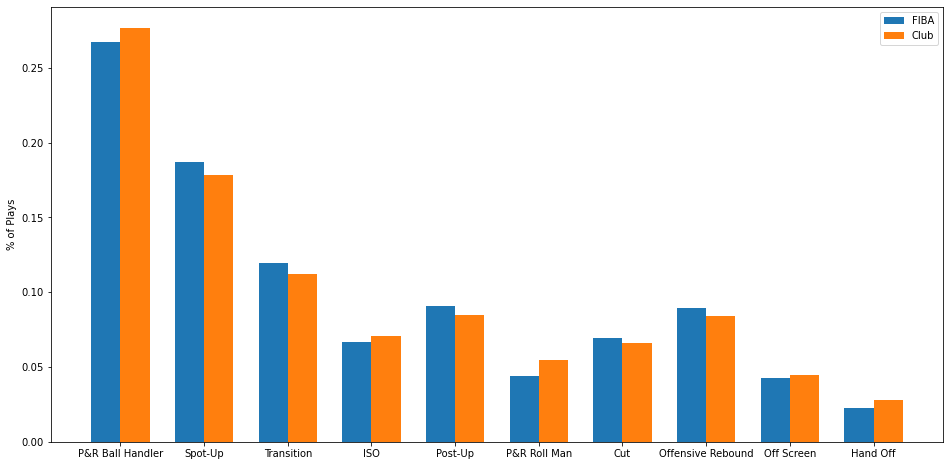

In [19]:
all_plays_df = df.groupby('Type')[play_types].sum()
all_plays_df = all_plays_df.div(all_plays_df.sum(axis=1), axis=0)
plt.figure(figsize = (16,8))
plt.bar([x for x in range(10)], all_plays_df.loc['FIBA'], width = 0.35, label = 'FIBA')
plt.bar([x + 0.35 for x in range(10)], all_plays_df.loc['Club'], width = 0.35, label = 'Club')
plt.xticks([i+0.175 for i in range(10)], play_types)
plt.legend()
plt.ylabel('% of Plays')
plt.show()

From this chart, we see that Post-up, Isolation, and Transition plays are more common in FIBA while P&R Roll Man and Spot-Ups were more common in Club Leagues. We can further investigate these trends by looking comparing between FIBA, NBA, and INTL play separately.

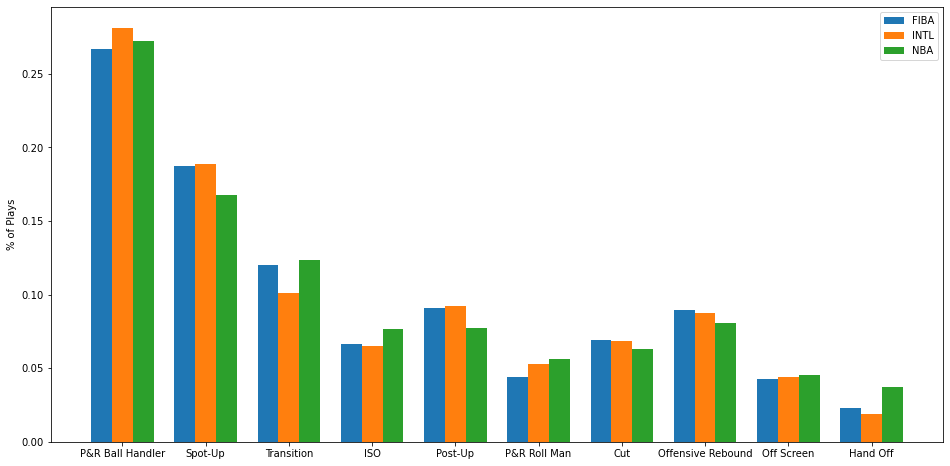

In [20]:
all_plays_df = df.groupby('Source')[play_types].sum()
all_plays_df = all_plays_df.div(all_plays_df.sum(axis=1), axis=0)
plt.figure(figsize = (16,8))
offsets = [0, 0.25, 0.5]
for i in range(len(sources)):
    source = sources[i]
    offset = offsets[i]
    plt.bar([x + offset for x in range(10)], all_plays_df.loc[source], width = 0.25, label = source)
plt.xticks([i+0.25 for i in range(10)], play_types)
plt.legend()
plt.ylabel('% of Plays')
plt.show()

From this chart, we can make some interesting observations. For example, we see that P&R Ball Handler, Spot-Up and Post-Up plays are far more common in FIBA and INTL leagues compare to the NBA, while Transition, Cut and P&R Roll Man plays are more common in the NBA compared to FIBA and INTl leagues. These observations generally make sense, as P&R Ball Handler, Spot-Up and Post-Up plays represent a more "Global" and more static style of basketball, while Transition, Cut and P&R Roll Man plays represent a more dynamic style of basketball. 

Now, we can also check which players switch clusters between their Club team and FIBA team. For example, we can compare players who move from cluster 1 (Playmakers) in Club play to cluster 6 (Off-Ball Wings) in FIBA play. Below, we see that many of these players are American NBA players who take smaller roles on the USA FIBA team. 

In [21]:
def get_players_by_switch(club_cluster, fiba_cluster):
    return club_clusters[club_clusters == club_cluster].index.intersection(fiba_clusters[fiba_clusters == fiba_cluster].index).tolist()

print("Players switching from cluster 1 (Club) to 6 (FIBA):")
print(', '.join(get_players_by_switch(1, 6)))

Players switching from cluster 1 (Club) to 6 (FIBA):
ANDREW RAUTINS, ANDREW WIGGINS, BLAKE SCHILB, BRADY HESLIP, CAMERON GLIDDON, DAMJAN STOJANOVSKI, DANILO ANDJUSIC, DEMAR DEROZAN, DONTA SMITH, DRAGAN MILOSAVLJEVIC, EDWIN JACKSON, JEAN SALUMU, JIMMY BUTLER, KARSTEN TADDA, KEVIN DURANT, LUCIO REDIVO, MARKO SUTALO, NEMANJA VRANJES, NICOLAS BATUM, PAUL GEORGE, PAVEL ILIN, STEPHEN CURRY, TOLGA GECIM
